In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Class for a single LinUCB disjoint arm
class linucb_disjoint_arm:
    def __init__(self, arm_index, d, alpha):
        self.arm_index = arm_index
        self.alpha = alpha
        self.A = np.identity(d)
        self.b = np.zeros([d, 1])

    def calc_UCB(self, x_array):
        A_inv = np.linalg.inv(self.A)
        self.theta = np.dot(A_inv, self.b)
        x = x_array.reshape([-1, 1])
        p = np.dot(self.theta.T, x) + self.alpha * np.sqrt(np.dot(x.T, np.dot(A_inv, x)))
        return p

    def reward_update(self, reward, x_array):
        x = x_array.reshape([-1, 1])
        self.A += np.dot(x, x.T)
        self.b += reward * x

In [3]:
# LinUCB policy class for managing multiple arms
class linucb_policy:
    def __init__(self, K_arms, d, alpha):
        self.K_arms = K_arms
        self.linucb_arms = [linucb_disjoint_arm(arm_index=i, d=d, alpha=alpha) for i in range(K_arms)]

    def select_arm(self, x_array):
        highest_ucb = -1
        candidate_arms = []
        
        for arm_index in range(self.K_arms):
            arm_ucb = self.linucb_arms[arm_index].calc_UCB(x_array)
            if arm_ucb > highest_ucb:
                highest_ucb = arm_ucb
                candidate_arms = [arm_index]
            elif arm_ucb == highest_ucb:
                candidate_arms.append(arm_index)
        
        chosen_arm = np.random.choice(candidate_arms)
        return chosen_arm

In [4]:
# Function to generate synthetic data for CTR simulation
def generate_synthetic_data(num_samples, K_arms, d):
    data = []
    arm_probabilities = np.linspace(0.05, 0.5, K_arms)  # Click probabilities for each arm

    for _ in range(num_samples):
        arm = np.random.randint(1, K_arms + 1)  # Arm chosen by logging policy (1 to K_arms)
        reward = np.random.binomial(1, arm_probabilities[arm - 1])  # Reward based on arm's probability
        covariates = np.random.normal(0, 1, d)  # Generate d-dimensional feature vector
        data.append((arm, reward, covariates))
    
    return data

In [5]:
# Function to simulate CTR using LinUCB on synthetic data
def ctr_simulator(K_arms, d, alpha, synthetic_data):
    linucb_policy_object = linucb_policy(K_arms=K_arms, d=d, alpha=alpha)
    aligned_time_steps = 0
    cumulative_rewards = 0
    aligned_ctr = []

    for data_arm, data_reward, data_x_array in synthetic_data:
        arm_index = linucb_policy_object.select_arm(data_x_array)

        if arm_index + 1 == data_arm:
            linucb_policy_object.linucb_arms[arm_index].reward_update(data_reward, data_x_array)
            aligned_time_steps += 1
            cumulative_rewards += data_reward
            aligned_ctr.append(cumulative_rewards / aligned_time_steps)

    return aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object

In [6]:
# Set parameters
K_arms = 10  # Number of arms
d = 100      # Number of covariates
alpha = 1.5  # Exploration parameter
num_samples = 1000  # Number of samples in synthetic dataset

In [7]:
# Generate synthetic data
synthetic_data = generate_synthetic_data(num_samples, K_arms, d)

# Run the CTR simulation with synthetic data
aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(
    K_arms=K_arms, d=d, alpha=alpha, synthetic_data=synthetic_data
)

In [8]:
# Display results
print(f"Aligned time steps: {aligned_time_steps}")
print(f"Cumulative rewards: {cum_rewards}")
print(f"Final CTR: {aligned_ctr[-1] if aligned_ctr else 0:.4f}")

Aligned time steps: 91
Cumulative rewards: 26
Final CTR: 0.2857


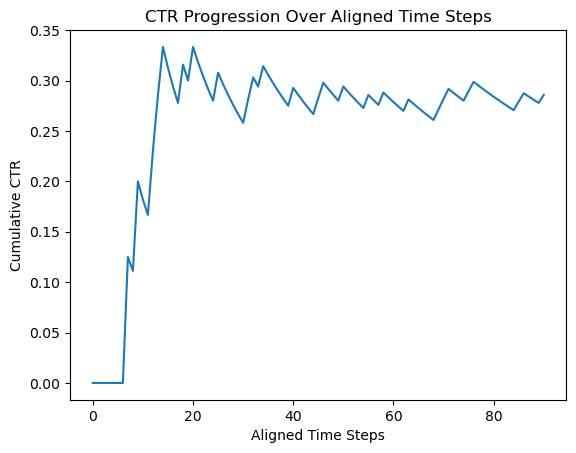

In [9]:
# Plot CTR progression
plt.plot(aligned_ctr)
plt.xlabel("Aligned Time Steps")
plt.ylabel("Cumulative CTR")
plt.title("CTR Progression Over Aligned Time Steps")
plt.show()